# Data Release Tutorial for [Properties of the binary neutron star merger GW170817](https://arxiv.org/abs/1805.11579)

This notebook serves as a basic introduction to loading and viewing data released in associaton with the publication titled **Properties of the binary neutron star merger GW170817** [arXiv](https://arxiv.org/abs/1805.11579)[DCC](https://dcc.ligo.org/LIGO-P1800061/public).

The data used in these tutorials will be downloaded from the public DCC page [LIGO-P1800061](https://dcc.ligo.org/LIGO-P1800061/public).

In [1]:
public_dcc_url='https://dcc.ligo.org/public/0150/P1800061/009/'

## PSDs

We'll take a look at the noise power spectral density (PSD) for each detector first.  We'll download this and other data from the [DCC entry](https://dcc.ligo.org/LIGO-P1800061/public) using `curl`.

In [2]:
!curl -O {public_dcc_url}"GW170817_PSDs.dat"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13.8M  100 13.8M    0     0   683k      0  0:00:20  0:00:20 --:--:--  630k


In order to read-in the data, this notebook uses `pandas` (http://pandas.pydata.org/). Other packages such as `numpy` (http://www.numpy.org/) will work as well.  We'll also use `matplotlib` (https://matplotlib.org/) for in-line figures.

In [3]:
%matplotlib inline

import pandas as pd

In [4]:
# reading the GW170817_PSDs.dat file
PSD = pd.read_table('GW170817_PSDs.dat', index_col=0, escapechar='#')

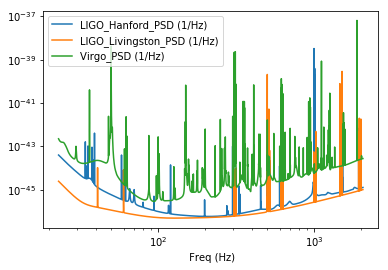

In [5]:
# plotting
PSD.plot(loglog=True);

## Posterior Samples

Now we'll download the released ten-dimensional posterior samples. The `IMRPhenomPNRT` samples are in the `high_spin_PhenomPNRT_posterior_samples.dat.gz` and `low_spin_PhenomPNRT_posterior_samples.dat.gz` files, for the "high-spin" and "low-spin" priors, respectively. (See the paper for details).

In [6]:
!curl -O {public_dcc_url}"high_spin_PhenomPNRT_posterior_samples.dat.gz"
!curl -O {public_dcc_url}"low_spin_PhenomPNRT_posterior_samples.dat.gz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  971k  100  971k    0     0   362k      0  0:00:02  0:00:02 --:--:--  362k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  423k  100  423k    0     0   376k      0  0:00:01  0:00:01 --:--:--  376k


In [7]:
# reading the high_spin_PhenomPNRT_posterior_samples.dat.gz file
high_spin = pd.read_table('high_spin_PhenomPNRT_posterior_samples.dat.gz',
                          delim_whitespace=True)

In [8]:
# checking the content:
high_spin.head()

,costheta_jn,luminosity_distance_Mpc,m1_detector_frame_Msun,m2_detector_frame_Msun,lambda1,lambda2,spin1,spin2,costilt1,costilt2
0,-0.993596,47.728797,1.911550,1.010550,365.345507,99.242133,0.084102,0.129488,0.683080,0.767114
1,-0.954812,42.051751,2.339391,0.850591,19.952612,3270.621882,0.761975,0.325375,0.266637,-0.396995
2,-0.986323,44.378266,2.098759,0.931645,23.518184,907.312802,0.649165,0.004049,0.180002,-0.152065
3,-0.454467,28.789020,1.700900,1.122544,312.021073,740.124071,0.146863,0.295022,0.599691,-0.194045
4,-0.948537,43.966578,1.567364,1.211268,327.764681,779.762955,0.071833,0.148521,0.701276,-0.336068


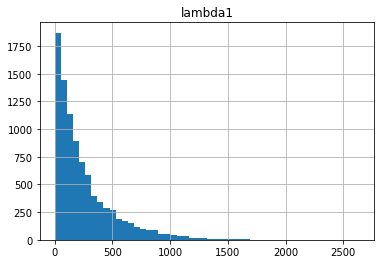

In [9]:
# 1D histogram of the "lambda1" parameter
high_spin.hist(column='lambda1', bins=50);

In [10]:
# reading the low_spin_PhenomPNRT_posterior_samples.dat.gz file
low_spin = pd.read_table('low_spin_PhenomPNRT_posterior_samples.dat.gz',delim_whitespace=True)

Optionally to make plotting simpler, we can concatenate the "high_spin" and "low_spin" posterior data:

In [11]:
high_spin['prior'] = "high_spin"
low_spin['prior'] = "low_spin"
data = pd.concat([high_spin, low_spin])

This notebook uses here seaborn (https://seaborn.pydata.org/, based on matplotlib) for plotting. Other packages such as directly matplotlib (https://matplotlib.org/) will work as well.

In [12]:
import seaborn as sns

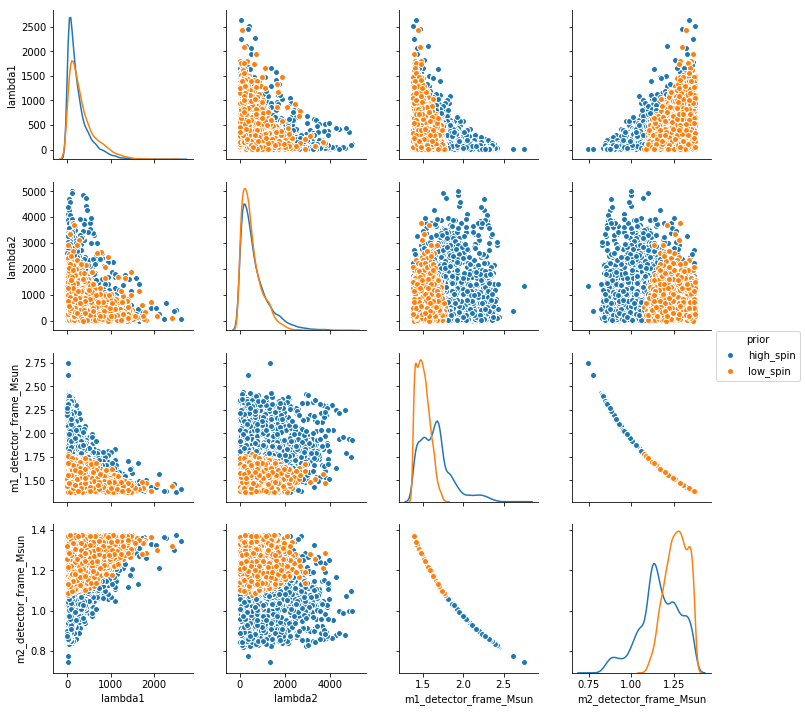

In [13]:
# Plotting several parameters' pair-wise relationships
sns.pairplot(data, vars=["lambda1", "lambda2", "m1_detector_frame_Msun", "m2_detector_frame_Msun", ],
             hue='prior', diag_kind="kde");

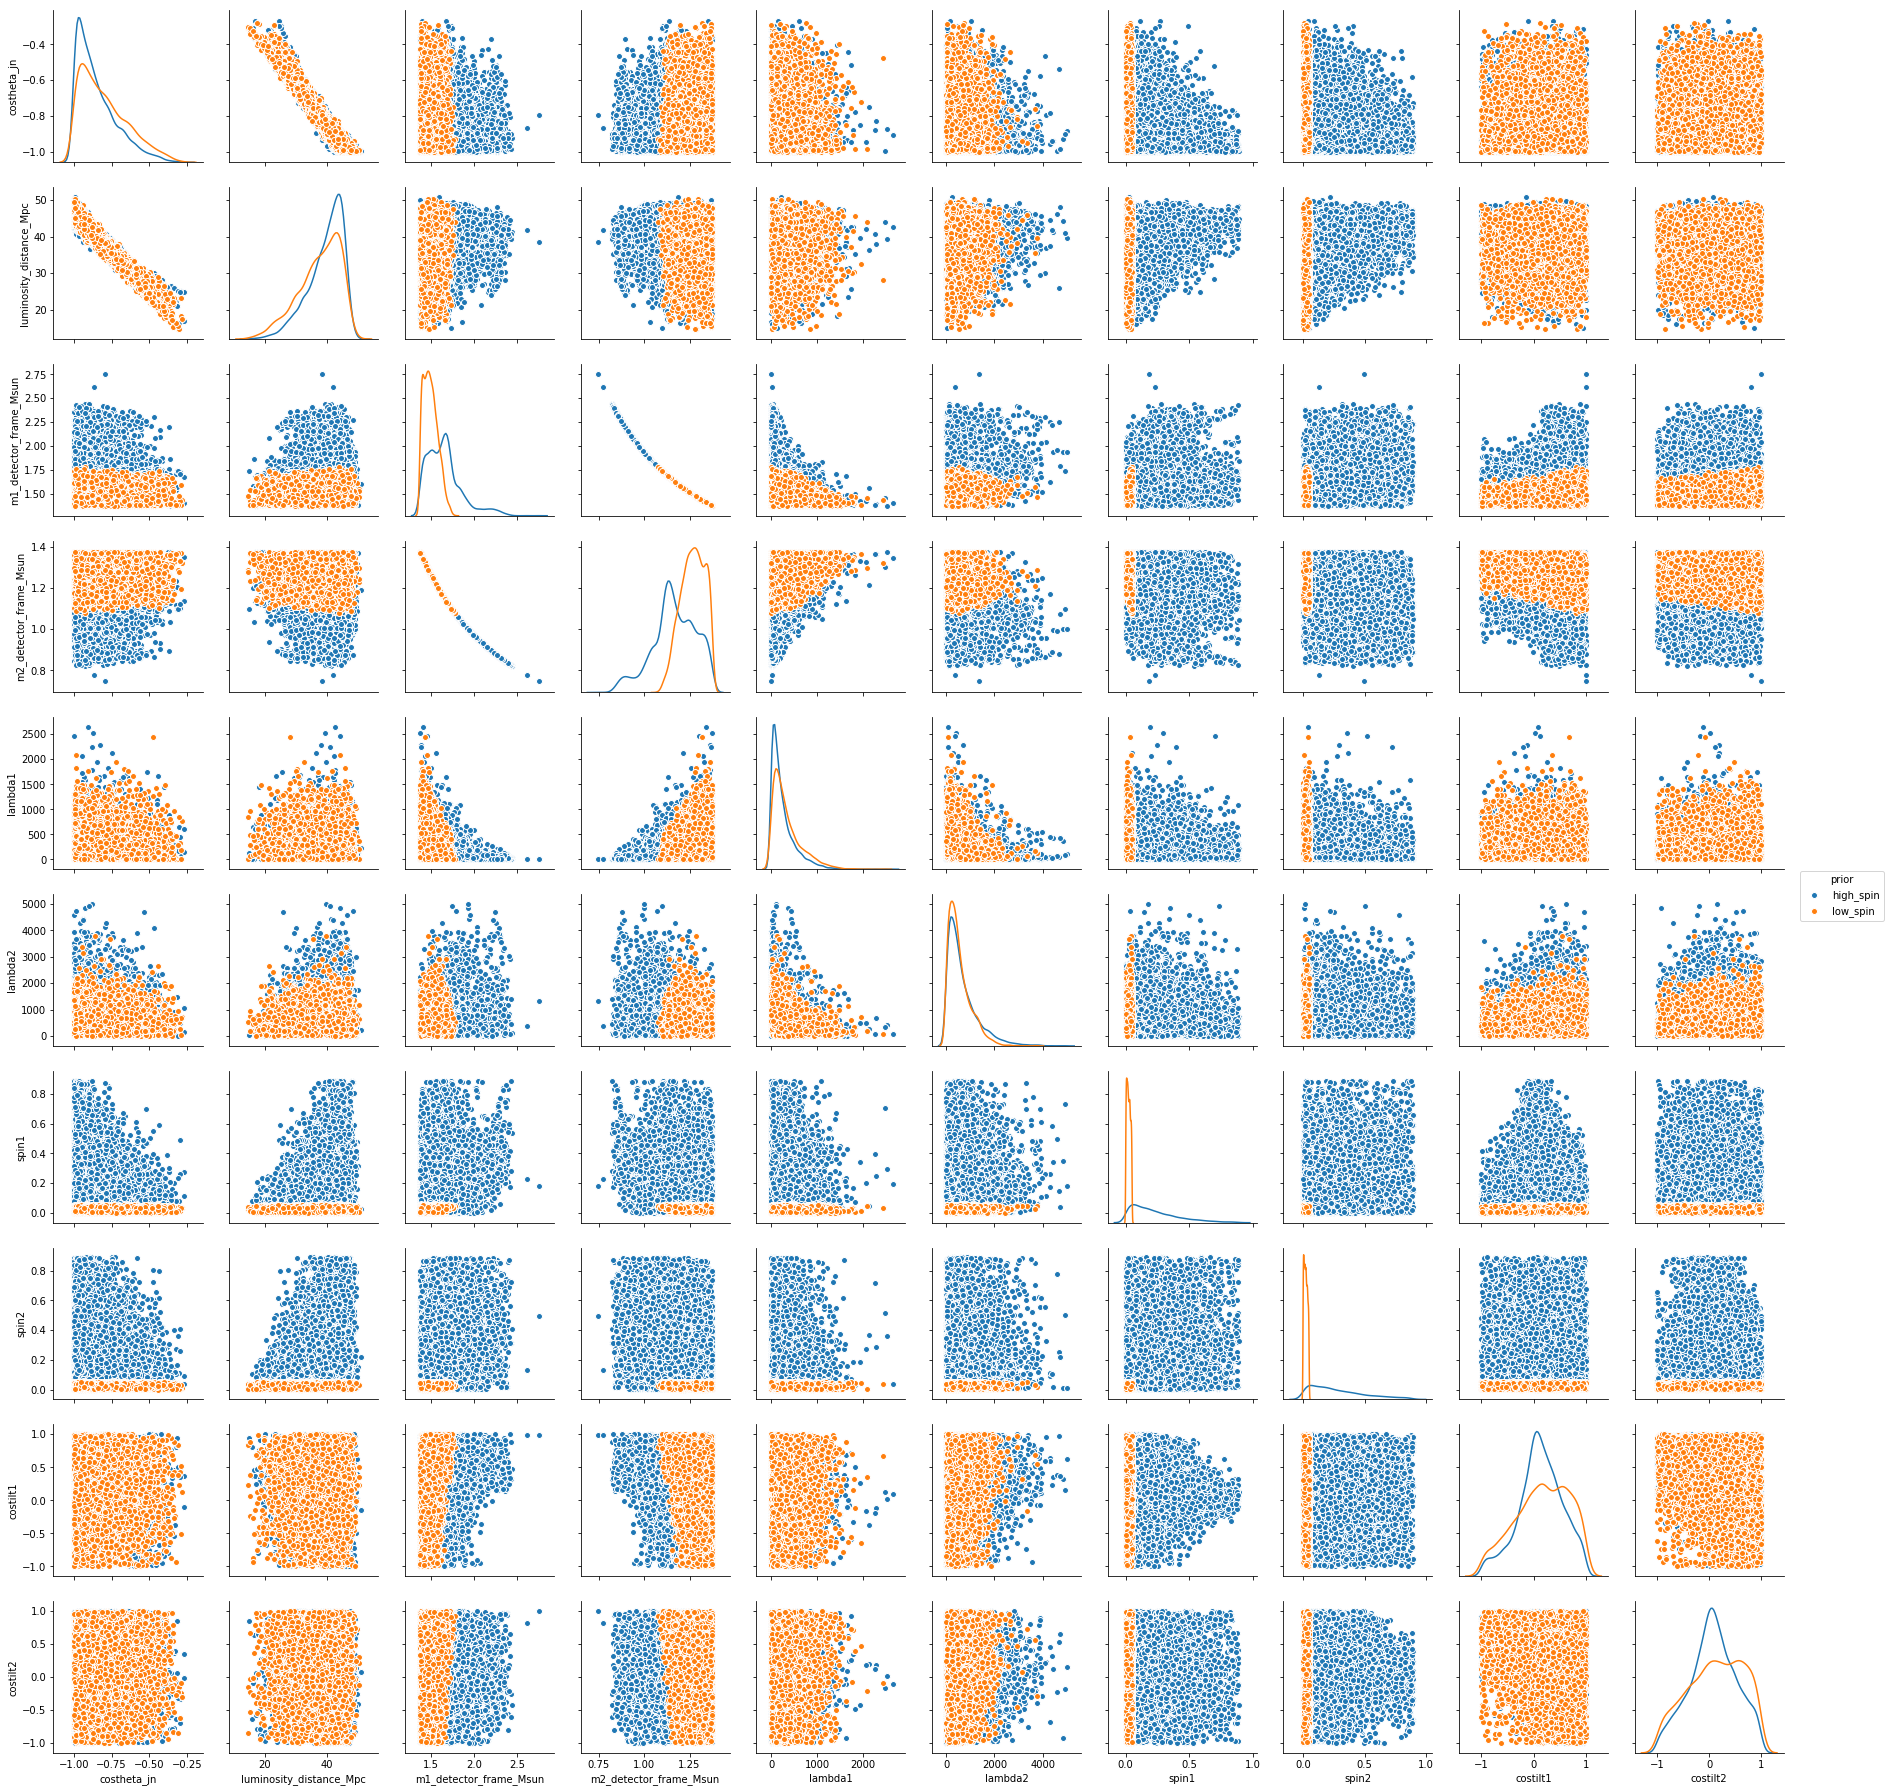

In [14]:
# Now for all parameters
sns.pairplot(data, hue='prior', diag_kind="kde");

## Sky Localization

Now we'll load the `FITS` files associated with the localization of the source from gravitational wave data alone.

This will use some plotting routines from [`ligo.skymap`](https://leo-singer.docs.ligo.org/ligo.skymap/), which is a `pip install` away.  We'll also use `numpy`, `healpy` (https://healpy.readthedocs.io), and `astropy` (http://www.astropy.org/), which are all dependencies of `ligo.skymap`, and should be installed automatically by `pip`.

In [15]:
import numpy as np
from matplotlib import pyplot as plt

import healpy as hp

from astropy.coordinates import SkyCoord
from astropy import units as u

from ligo.skymap import io
from ligo.skymap import plot
from ligo.skymap.postprocess import find_greedy_credible_levels

/Users/bfarr/Virtualenvs/astropy/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


The FITS files are packaged together as part of the Figure 3 data release.  First we'll download and extract the data.

In [16]:
!curl -O {public_dcc_url}"figure_3.tar.gz"
!tar -xvf figure_3.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1082k  100 1082k    0     0   454k      0  0:00:02  0:00:02 --:--:--  454k
x figure_3/
x figure_3/discovery_skymap.fits.gz
x figure_3/updated_skymap.fits.gz
x figure_3/README.md


In [17]:
# Read the sky maps from the FITS files
discovery_skymap, discovery_metadata = io.read_sky_map('figure_3/discovery_skymap.fits.gz')
updated_skymap, updated_metadata = io.read_sky_map('figure_3/updated_skymap.fits.gz')

We'll also save the location information for [SSS17a](https://arxiv.org/abs/1710.05452).

In [18]:
SSS17a = SkyCoord(197.4503*u.deg, -23.3815*u.deg)

### Credible Intervals

Calculate credible intervals from the posteriors.

In [19]:
discovery_cl = find_greedy_credible_levels(discovery_skymap)
updated_cl = find_greedy_credible_levels(updated_skymap)

In [20]:
discovery_area = int(np.round(np.sum(discovery_cl <= 0.9) * hp.nside2pixarea(hp.npix2nside(len(discovery_skymap)), degrees=True)))
updated_area = int(np.round(np.sum(updated_cl <= 0.9) * hp.nside2pixarea(hp.npix2nside(len(updated_skymap)), degrees=True)))

print("Area of 90% credible region from initial analysis: {} sq. deg.".format(discovery_area))
print("Area of 90% credible region from updated analysis: {} sq. deg.".format(updated_area))

Area of 90% credible region from initial analysis: 28 sq. deg.
Area of 90% credible region from updated analysis: 16 sq. deg.


### Sky Map

Now let's plot the sky maps.

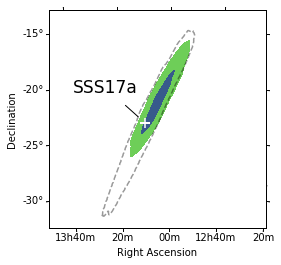

In [21]:
fig = plt.figure()
ax = plt.axes(projection='astro zoom', center='13h05m -23d', radius='10deg')

ax.coords['ra'].set_major_formatter('hh:mm')

ax.contour_hpx(discovery_cl, levels=[0.9], colors='k', alpha=0.4, linestyles='--')
ax.contourf_hpx(updated_cl, levels=[0, 0.5, 0.9])

ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

xytext = (SSS17a.ra.deg + 7, SSS17a.dec.deg + 3)
ax.annotate('SSS17a', xy=(SSS17a.ra.deg, SSS17a.dec.deg), xytext=xytext, fontsize=17,
            arrowprops=dict(arrowstyle="-", shrinkA=10, shrinkB=10),
            xycoords=ax.get_transform('world'), textcoords=ax.get_transform('world'))

ax.scatter(SSS17a.ra.deg, SSS17a.dec.deg, s=100, transform=ax.get_transform('world'), marker='+', color='white');

## Distance and Inclination

Now we'll work with the data released in association with figure 4.

In [22]:
!curl -O {public_dcc_url}"figure_4.tar.gz"
!tar -xvf figure_4.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  465k  100  465k    0     0   391k      0  0:00:01  0:00:01 --:--:--  391k
x figure_4/
x figure_4/volumetric_marginal_posterior_pdf.dat.gz
x figure_4/dist_grid_pts.dat.gz
x figure_4/README.md
x figure_4/em_dist_prior_marginal_posterior_pdf.dat.gz
x figure_4/incl_grid_pts.dat.gz


The release includes the values of the 2-D marginal posterior distributions plotted in figure 4, which are the result of two different prior distributions (see paper for details).  We'll load the 2-D grid points, and the values of the posterior distributions.

In [23]:
# Grid points in distance and inclination (theta_jn)
XX = np.loadtxt('./figure_4/incl_grid_pts.dat.gz')
YY = np.loadtxt('./figure_4/dist_grid_pts.dat.gz')

# Posterior PDF values for the marginal distributions shown in Figure 4
gw_Z = np.loadtxt('./figure_4/volumetric_marginal_posterior_pdf.dat.gz')
em_Z = np.loadtxt('./figure_4/em_dist_prior_marginal_posterior_pdf.dat.gz')

### 2-D Marginal Posterior Distributions

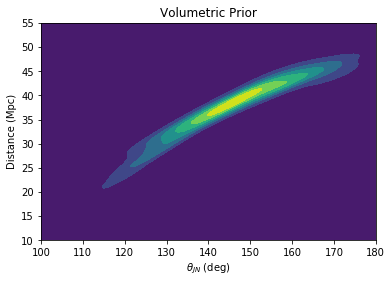

In [24]:
# Plot the posterior corresponding to the GW-only, volumetric prior
plt.contourf(XX, YY, gw_Z)

plt.title('Volumetric Prior')
plt.xlabel(r'$\theta_{JN}$ (deg)')
plt.ylabel('Distance (Mpc)');

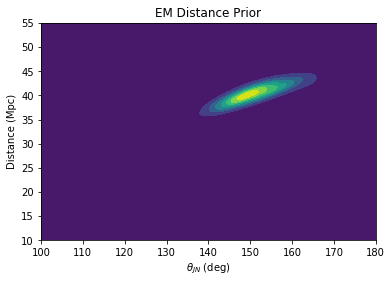

In [25]:
# Plot the posterior corresponding to the EM-constrained distance prior
plt.contourf(XX, YY, em_Z)

plt.title('EM Distance Prior')
plt.xlabel(r'$\theta_{JN}$ (deg)')
plt.ylabel('Distance (Mpc)');

### 1-D Marginal Posterior Distributions

We can now marginalize (i.e., integrate over) one parameter to get the resulting 1-D marginal posterior distribution in the other parameter.

In [26]:
# Extract the 1-D grids for 1-D marginal distribution plots
theta_jns = XX[0, :]
d_theta_jn = theta_jns[1] - theta_jns[0]

dists = YY[:, 0]
d_dist = dists[1] - dists[0]

#### Inclination

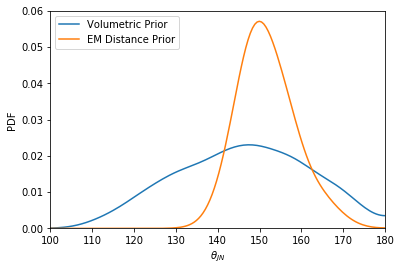

In [27]:
plt.plot(theta_jns, d_dist*np.sum(gw_Z, axis=0), label='Volumetric Prior')
plt.plot(theta_jns, d_dist*np.sum(em_Z, axis=0), label='EM Distance Prior')
plt.xlim(theta_jns[0], theta_jns[-1])
plt.ylim(ymin=0)
plt.legend(loc='upper left')

plt.xlabel(r'$\theta_{JN}$')
plt.ylabel('PDF');

#### Distance

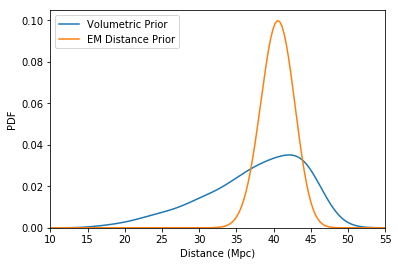

In [28]:
plt.plot(dists, d_dist*np.sum(gw_Z, axis=1), label='Volumetric Prior')
plt.plot(dists, d_dist*np.sum(em_Z, axis=1), label='EM Distance Prior')
plt.xlim(dists[0], dists[-1])
plt.ylim(ymin=0)
plt.legend(loc='upper left')

plt.xlabel('Distance (Mpc)')
plt.ylabel('PDF');